In [53]:
print('The "Liquidity" just started running')

The "Liquidity" just started running


Выбор условий выполнения скрипта:

In [54]:
Print_to_excel = False # Создать excel-файл с расчетами? True/False
Print_qualuty_check = True # Вынести QC в отдельный excel-файл? True/False
Send_mail = False # Создать и отправить письмо с расчетами и графиком? True/False
Send_QC_mail = False # Создать и отправить письмо для QC? True/False

Необходимые импорты:

In [55]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
from openpyxl.drawing.image import Image

import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column
from Defs import concat_columns

Cash:

In [56]:
query = """
SELECT "holding", SUM("balanceUsd") AS "cash", "reportDate"
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "accountStatus" = 'active' AND "bankCountryCode" = 'RU' 
AND "reportDate" >= trunc(sysdate - interval '3' month)
GROUP BY "holding", "reportDate"
ORDER BY "reportDate"
"""

data_cash = export_from_RISKCUSTOM(query)
data_cash['merge_col'] = data_cash[['holding', 'reportDate']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_cash = data_cash.sort_values(['reportDate', 'holding']).reset_index(drop=True)
data_cash.tail(6)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,holding,cash,reportDate,merge_col
120,EUROCHEM,3.629150e+07,2024-04-10,EUROCHEM_2024-04-10 00:00:00
121,SUEK,4.020397e+07,2024-04-10,SUEK_2024-04-10 00:00:00
122,EUROCHEM,5.584301e+07,2024-04-11,EUROCHEM_2024-04-11 00:00:00
123,SUEK,3.833059e+07,2024-04-11,SUEK_2024-04-11 00:00:00
124,EUROCHEM,4.027168e+07,2024-04-12,EUROCHEM_2024-04-12 00:00:00
125,SUEK,4.053351e+07,2024-04-12,SUEK_2024-04-12 00:00:00


In [57]:
query = """
SELECT "companyCode" AS "holding", SUM("bookValuePositionCurrency") AS "pre_overdraft", "reportDate"
FROM "RISKACCESS"."sapPositionArrears"
WHERE "productType" = 130 AND "companyCode" IN ('1100', 'E200') 
AND "reportDate" >= trunc(sysdate - interval '3' month) AND "reportDate" <= (SELECT MAX("reportDate") FROM "RISKACCESS"."bankAccountsBalanceDaily")
GROUP BY "companyCode", "reportDate"
ORDER BY "reportDate"
"""

data_overdraft = export_from_RISKCUSTOM(query) # выгрузка запроса
data_overdraft.holding = data_overdraft.holding.replace({'1100': 'SUEK', 'E200':'EUROCHEM'}) # Переименовывание holding
data_overdraft['merge_col'] = data_overdraft[['holding', 'reportDate']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_overdraft = data_overdraft.sort_values(['reportDate', 'holding']).reset_index(drop=True)
data_overdraft.tail(6)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,holding,pre_overdraft,reportDate,merge_col
69,EUROCHEM,1.303058e+09,2024-04-10,EUROCHEM_2024-04-10 00:00:00
70,SUEK,1.030423e+09,2024-04-10,SUEK_2024-04-10 00:00:00
71,EUROCHEM,3.912134e+09,2024-04-11,EUROCHEM_2024-04-11 00:00:00
72,SUEK,3.424786e+09,2024-04-11,SUEK_2024-04-11 00:00:00
73,EUROCHEM,6.142121e+09,2024-04-12,EUROCHEM_2024-04-12 00:00:00
74,SUEK,4.169484e+09,2024-04-12,SUEK_2024-04-12 00:00:00


In [58]:
data_total = data_cash.merge(data_overdraft, how='outer', left_on='merge_col', right_on='merge_col')
data_total = data_total.loc[~data_total.cash.isna(), ['reportDate_x', 'holding_x', 'cash', 'pre_overdraft']].rename(columns={'reportDate_x':'reportDate', 'holding_x':'holding'}).reset_index(drop=True)
data_total.pre_overdraft = data_total.pre_overdraft.fillna(0) # Заполнение пустых значений pre_overdraft нулями
limit_df = pd.DataFrame({'holding': ['SUEK', 'EUROCHEM'], 'limit': [15000000000, 8000000000]}) # Добавление значения limit для каждого holding
data_total = data_total.merge(limit_df, how='left')
data_total['overdraft'] = data_total.limit - data_total.pre_overdraft # Вычисление overdraft

data_total['CCY'] = 'RUB'
data_total = add_in_currency_column(df=data_total, col_with_CCY='CCY', col_with_VAL='overdraft', CCY_to='USD', date_is_column=True, DATE = 'reportDate')
data_total = data_total.rename(columns={'overdraft_in_USD':'available_ovedraft'})

data_total['total'] = data_total.cash + data_total.available_ovedraft # расчет total
const_df = pd.DataFrame({'holding':['EUROCHEM', 'SUEK'], 'early_trigger': [164, 251], 'threshold': [93, 183]})
data_total = data_total.merge(const_df, how='left')
data_total[['cash', 'available_ovedraft', 'total']] = data_total[['cash', 'available_ovedraft', 'total']].astype(int).apply(lambda z: z/10**6)
data_total['day_of_week'] = data_total.reportDate.dt.day_of_week
data_total.head(2)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:147: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[f'Coef_to_{CCY_to}'] = df.date_CCY_from.replace(coef_dict)


,reportDate,holding,cash,pre_overdraft,limit,overdraft,CCY,Coef_to_USD,available_ovedraft,total,early_trigger,threshold,day_of_week
0,2024-01-16,EUROCHEM,13.228465,603130705.5,8000000000,7.396869e+09,RUB,0.011325,83.767761,96.996227,164,93,1
1,2024-01-17,EUROCHEM,27.275681,486129153.6,8000000000,7.513871e+09,RUB,0.011315,85.018831,112.294513,164,93,2


In [59]:
data_cash.shape, data_overdraft.shape, data_total.shape

((126, 4), (75, 4), (126, 13))

Графики:

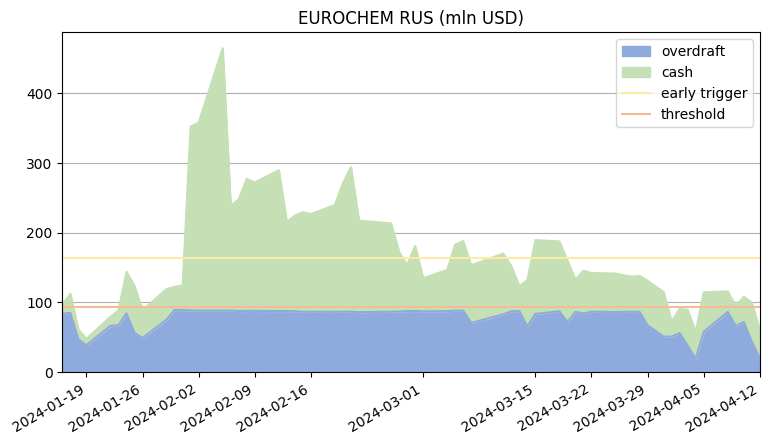

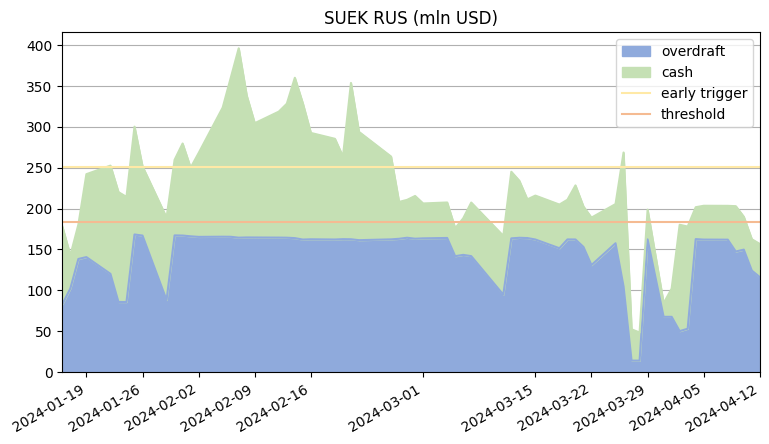

In [60]:
for i in ['EUROCHEM', 'SUEK']:
    data_plot = data_total.query("holding==@i")
    xticks = data_plot.loc[data_plot.day_of_week.isin([4]), 'reportDate'].sort_values().tolist() # Каждая n-ый день недели в качестве делелния на оси X
    # xticks = data_plot.reportDate.tolist()[::4] # Каждая n-я дата в качестве делелния на оси X
    title = i + ' RUS (mln USD)'
    ax = data_plot.plot(x='reportDate', y=['available_ovedraft', 'cash'], kind='area', stacked=True, figsize=[9, 5], title=title, color=['#8faadc', '#c5e0b4'], xticks=xticks)
    ax.axhline(y=data_plot.early_trigger.tolist()[0], color='#ffe9a6', label='early_trigger')
    ax.axhline(y=data_plot.threshold.tolist()[0], color='#f5bb92', label='threshold')
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles = handles[0:], labels=['overdraft', 'cash','early trigger', 'threshold'])
    start, end = data_plot.reportDate.min(), data_plot.reportDate.max()
    ax.set_xlim([start, end])
    ax.set_axisbelow ( True )
    ax.grid(axis='y')
    ax.set(xlabel=None)
    plt.savefig(f'{i}.png')


Запись в файл:

In [61]:
TD = data_total.reportDate.max()
TD_str = str(TD)[:10]
Output_file_SUEK = TD_str + '_Oper_liquidity_SUEK.xlsx'
Output_file_ECH = TD_str + '_Oper_liquidity_EUROCHEM.xlsx'

if Print_to_excel == True:
  for i in ['EUROCHEM', 'SUEK']:
      data_print = data_total.query("holding==@i")[['reportDate', 'cash', 'available_ovedraft', 'total', 'early_trigger', 'threshold']]
      Output_file = TD_str + '_Oper_liquidity_' + i + '.xlsx'
      data_print.to_excel(Output_file, index=False)
      # Create a new or open existing Excel file with openpyxl
      wb = openpyxl.load_workbook(Output_file)  # Open existing or create new
      ws = wb.active
      # Error handling: Check if image file exists
      try:
        img = Image(f'{i}.png')
      except FileNotFoundError:
        print("Error: Image file 'EUROCHEM.png' not found. Skipping image insertion.")
        img = None  # Set img to None to avoid potential errors
      # Insert image if it exists
      if img:
        img.anchor = 'H37'  # Adjust cell reference as needed
        ws.add_image(img)
      # Save the Excel file (overwrite if existing)
      wb.save(Output_file)

In [62]:
data_total.head(2)

,reportDate,holding,cash,pre_overdraft,limit,overdraft,CCY,Coef_to_USD,available_ovedraft,total,early_trigger,threshold,day_of_week
0,2024-01-16,EUROCHEM,13.228465,603130705.5,8000000000,7.396869e+09,RUB,0.011325,83.767761,96.996227,164,93,1
1,2024-01-17,EUROCHEM,27.275681,486129153.6,8000000000,7.513871e+09,RUB,0.011315,85.018831,112.294513,164,93,2


Quality_ckeck.Missing_records

In [63]:
query = """
SELECT *
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "reportDate" >= trunc(sysdate - interval '30' day)
ORDER BY "reportDate"
"""

data_QC_cash = export_from_RISKCUSTOM(query)
data_QC_cash.tail(3)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,##batch_id,##deleted,##inserted,##origin_name,reportDate,holding,buCode,buCountryGroup,buCountryCode,buName,bankName,bankId,bankCountryCode,bankCountryGroup,accountCurrency,accountNumber,accountStatus,balance,balanceUsd,statementDate
75824,35562813@WHPROD,N,2024-04-15 17:25:18,WHFLEX,2024-04-12,EUROCHEM,AREFO,(9) other,AR,Emerger Fertilizantes S.A.,Santander,BSCHAR,AR,(9) other,ARS,DC - LASCOMBES MARAD,active,50000.0,57.703405,2022-08-01
75825,35562813@WHPROD,N,2024-04-15 17:25:18,WHFLEX,2024-04-12,EUROCHEM,AREFO,(9) other,AR,Emerger Fertilizantes S.A.,Santander,BSCHAR,AR,(9) other,ARS,DC - RODRIGUEZ O,active,300000.0,346.220427,2022-08-01
75826,35562813@WHPROD,N,2024-04-15 17:25:18,WHFLEX,2024-04-12,EUROCHEM,AREFO,(9) other,AR,Emerger Fertilizantes S.A.,Santander,BSCHAR,AR,(9) other,ARS,DC- POMARADA LIEVAN,active,0.0,0.000000,2022-08-01


In [64]:
data_QC_cash['missing_record'] = data_QC_cash[['buCode', 'bankId', 'accountCurrency', 'accountNumber']].astype(str).apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

last_date = data_QC_cash.reportDate.unique()[-1]
pre_last_date = data_QC_cash.reportDate.unique()[-2]
data_QC_cash_pre_last_date = data_QC_cash.loc[data_QC_cash.reportDate == pre_last_date, 'missing_record'].tolist()
data_QC_cash_last_date = data_QC_cash.loc[data_QC_cash.reportDate == last_date, 'missing_record'].tolist()

missing_records = [i for i in data_QC_cash_pre_last_date if i not in data_QC_cash_last_date]

data_missing_records = data_QC_cash[(data_QC_cash.missing_record.isin(missing_records)) & (data_QC_cash.reportDate == pre_last_date)]
data_missing_records.head(2)

,##batch_id,##deleted,##inserted,##origin_name,reportDate,holding,buCode,buCountryGroup,buCountryCode,buName,...,bankId,bankCountryCode,bankCountryGroup,accountCurrency,accountNumber,accountStatus,balance,balanceUsd,statementDate,missing_record
68656,35486720@WHPROD,N,2024-04-12 14:50:20,WHFLEX,2024-04-11,EUROCHEM,USSUS,(4) US,US,SUEK AG Corp USA,...,BOFAUS,US,(4) US,USD,334056894512,active,443556.27,443556.27,2023-11-29,USSUS_BOFAUS_USD_334056894512
68665,35486720@WHPROD,N,2024-04-12 14:50:20,WHFLEX,2024-04-11,EUROCHEM,CNSST,(5) CN,CN,SST Beijing,...,BKCHCN,CN,(5) CN,CNY,348062745074,active,0.00,0.00,2023-11-23,CNSST_BKCHCN_CNY_348062745074


Quality_ckeck.New_records

In [65]:
new_records = [i for i in data_QC_cash_last_date if i not in data_QC_cash_pre_last_date]

data_new_records = data_QC_cash[(data_QC_cash.missing_record.isin(new_records)) & (data_QC_cash.reportDate == last_date)]
data_new_records.head(2)

,##batch_id,##deleted,##inserted,##origin_name,reportDate,holding,buCode,buCountryGroup,buCountryCode,buName,...,bankId,bankCountryCode,bankCountryGroup,accountCurrency,accountNumber,accountStatus,balance,balanceUsd,statementDate,missing_record
72282,35562813@WHPROD,N,2024-04-15 17:25:18,WHFLEX,2024-04-12,EUROCHEM,7Z00,(0) RU,RU,SUEK Logistic Moscow,...,ALFARU,RU,(0) RU,KZT,40807398401850000006,active,0.0,0.000000,2022-03-29,7Z00_ALFARU_KZT_40807398401850000006
72283,35562813@WHPROD,N,2024-04-15 17:25:18,WHFLEX,2024-04-12,EUROCHEM,7Z00,(0) RU,RU,SUEK Logistic Moscow,...,ALFARU,RU,(0) RU,RUB,40807810301850000341,active,15410.0,164.915311,2022-07-26,7Z00_ALFARU_RUB_40807810301850000341


Quality_ckeck.Mapping

In [66]:
data_QC_cash['Map_holding'] = merge_SalesUnits(data_QC_cash, col='buCode', merge_col='holding')
data_QC_cash['Map_holding_2'] = merge_SalesUnits(data_QC_cash, col='buCode', id_col='oebs12ShortCode', merge_col='holding')
data_QC_cash.loc[data_QC_cash.Map_holding_2 == 'External' ,'Map_holding_2'] = data_QC_cash.loc[data_QC_cash.Map_holding_2 == 'External' ,'Map_holding']
data_map_holding = data_QC_cash.loc[(data_QC_cash.Map_holding_2 != data_QC_cash.holding) & (data_QC_cash.reportDate == data_QC_cash.reportDate.max()), ['buCode', 'holding', 'Map_holding_2']].drop_duplicates()
data_map_holding

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,buCode,holding,Map_holding_2


Запись QC в файл:

In [67]:
str(last_date)[:10]
Output_file = str(last_date)[:10] + '_Oper_liquidity_QC.xlsx'

if Print_qualuty_check == True :
    data_missing_records.to_excel(Output_file, sheet_name='Пропавшие_счета')
    new_list(data_new_records, Output_file, sheet_name='Новые_счета', index=True)
    new_list(data_map_holding, Output_file, sheet_name='Поиск_в_SalesUnits')

Создание письма:

In [68]:
import win32com.client as win32
import os
olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

for i in ['EUROCHEM', 'SUEK']:
    mailItem = olApp.CreateItem(0)
    mailItem.BodyFormat = 3

    mailItem.Subject = f'Operational liquidity {i} RUS {TD_str}' # mail head
    # mail body
    html_body = f"""<html><body><p>Dear colleagues,<br><br>
    Please find attached daily operational liquidity report as of {TD_str}<br>
    <img src="{(os.path.join(os.getcwd(), i))}.png"><br>
    Below early trigger – to analyze if there is an issue with revenue collection and if there is a risk of threshold violation<br>
    Below threshold – an action plan to return above the threshold<br><br>
    Best regards,<br>
    Maksim Tarakanov<br><br>
    Whatsapp: +7 915 161 29 12<br>
    Financial risk management</p></body></html>"""
    mailItem.To = 'KlimovaAnnaA@aimmngt.com' # mail to
    mail_from = 'KlimovaAnnaA@aimmngt.com' # mail from
        # mail attachment
    if i == 'SUEK':
        mail_attachment = Output_file_SUEK 
    if i == 'EUROCHEM':
        mail_attachment = Output_file_ECH 

    mailItem._oleobj_.Invoke(*(64209, 0, 8, 0, olNS.Accounts.Item(mail_from)))
    mailItem.Attachments.Add(os.path.join(os.getcwd(), mail_attachment))
    mailItem.HTMLBody = html_body
    mailItem.Sensitivity  = 2

    # mailItem.Save()
    mailItem.Display()
    if Send_mail == True:
        mailItem.Send()

In [69]:
mailItem = olApp.CreateItem(0)
mailItem.BodyFormat = 3

mailItem.Subject = f'QC for operational liquidity {TD_str}' # mail head
# mail body
html_body = f"""<html><body><p>Dear colleagues,<br><br>
Please find attached quality control of daily operational liquidity report as of {TD_str}:<br><br>
&nbsp;&nbsp; Missed records - {'<span style="color: green;">OK</span>' if data_missing_records.empty else '<span style="color: red;">Alert</span>'}<br>
&nbsp;&nbsp; New records - {'<span style="color: green;">OK</span>' if data_new_records.empty else '<span style="color: red;">Alert</span>'}<br>
&nbsp;&nbsp; Finding in SalesUnits - {'<span style="color: green;">OK</span>' if data_map_holding.empty else '<span style="color: red;">Alert</span>'}<br><br>
Best regards,<br>
Maksim Tarakanov<br><br>
Whatsapp: +7 915 161 29 12<br>
Financial risk management</p></body></html>"""
mailItem.To = 'KlimovaAnnaA@aimmngt.com' # mail to
mail_from = 'KlimovaAnnaA@aimmngt.com' # mail from
# mail attachment
mail_attachment = Output_file 


mailItem._oleobj_.Invoke(*(64209, 0, 8, 0, olNS.Accounts.Item(mail_from)))
mailItem.Attachments.Add(os.path.join(os.getcwd(), mail_attachment))
mailItem.HTMLBody = html_body
mailItem.Sensitivity  = 2

# mailItem.Save()
mailItem.Display()
if Send_QC_mail == True:
    mailItem.Send()

In [70]:
print('The "Liquidity" was finished')

The "Liquidity" was finished
